In [1]:
pwd

'/home/jh20/Data/pet'

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
pet_df = pd.read_csv("/home/jh20/Data/pet/pet_metadata.csv")

In [4]:
pet_df

,type,species,mission-id,provider-code,breed,age,class,sex,weight,shoulder-height,...,disease,diseaseName,CRP,lgG,IL-6,AFP,heart-rate,breating-rate,body-heat,stress
0,B,10,10_001074,16,DRI,10.10,SS,CM,8.80,24.5,...,NOR,NaN,2.85,4.96,1.86,0.57,108,24,38.9,1.3
1,B,10,10_000929,16,CHI,11.10,SS,SF,2.50,19.0,...,ABN,CAR,1.48,8.68,4.44,0.55,142,33,38.1,8.6
2,B,10,10_000957,16,CHI,8.00,SS,SF,1.80,17.0,...,NOR,NaN,0.29,6.78,3.27,0.54,110,36,40.0,3.6
3,B,10,10_001074,16,DRI,10.10,SS,CM,8.80,24.5,...,NOR,NaN,2.85,4.96,1.86,0.57,108,24,38.9,1.3
4,B,10,10_000929,16,CHI,11.10,SS,SF,2.50,19.0,...,ABN,CAR,1.48,8.68,4.44,0.55,142,33,38.1,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,B,10,10_000929,16,CHI,11.10,SS,SF,2.50,19.0,...,ABN,CAR,1.48,8.68,4.44,0.55,142,33,38.1,8.6
144,B,10,10_001073,16,POO,5.25,SS,CM,3.86,22.0,...,NOR,NaN,1.15,10.76,3.60,0.55,142,33,40.0,8.9
145,B,10,10_000957,16,CHI,8.00,SS,SF,1.80,17.0,...,NOR,NaN,0.29,6.78,3.27,0.54,110,36,40.0,3.6
146,B,10,10_001075,16,POO,8.00,SS,CM,8.30,30.0,...,NOR,NaN,0.72,4.09,4.47,0.54,124,36,38.4,3.2


In [7]:
pet_df.BCS.value_counts()

5    55
6    38
4    37
7    18
Name: BCS, dtype: int64

In [5]:
data_df = pet_df.loc[~pet_df['body-part'].isin([1,2,13,14,15,16,17,18,19,20]),:]

In [9]:
data_id_lst = []

for i,j in zip(data_df['mission-id'],data_df['body-part']):
#     print(i,j)
    data_id_lst.append(i+ '_' + str(j).zfill(2))

In [115]:
data_df['data_id'] = data_id_lst

/home/jh20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
data_df

,type,species,mission-id,provider-code,breed,age,class,sex,weight,shoulder-height,...,disease,diseaseName,CRP,lgG,IL-6,AFP,heart-rate,breating-rate,body-heat,stress
0,B,10,10_001074,16,DRI,10.10,SS,CM,8.80,24.5,...,NOR,NaN,2.85,4.96,1.86,0.57,108,24,38.9,1.3
2,B,10,10_000957,16,CHI,8.00,SS,SF,1.80,17.0,...,NOR,NaN,0.29,6.78,3.27,0.54,110,36,40.0,3.6
3,B,10,10_001074,16,DRI,10.10,SS,CM,8.80,24.5,...,NOR,NaN,2.85,4.96,1.86,0.57,108,24,38.9,1.3
4,B,10,10_000929,16,CHI,11.10,SS,SF,2.50,19.0,...,ABN,CAR,1.48,8.68,4.44,0.55,142,33,38.1,8.6
5,B,10,10_000930,16,POM,4.10,SS,CM,6.86,31.0,...,NOR,NaN,6.55,5.92,2.82,0.55,120,21,38.7,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,B,10,10_001088,10,POO,2.00,SS,CM,8.80,34.0,...,NOR,NaN,0.24,5.10,2.11,0.55,84,24,39.0,1.3
143,B,10,10_000929,16,CHI,11.10,SS,SF,2.50,19.0,...,ABN,CAR,1.48,8.68,4.44,0.55,142,33,38.1,8.6
144,B,10,10_001073,16,POO,5.25,SS,CM,3.86,22.0,...,NOR,NaN,1.15,10.76,3.60,0.55,142,33,40.0,8.9
146,B,10,10_001075,16,POO,8.00,SS,CM,8.30,30.0,...,NOR,NaN,0.72,4.09,4.47,0.54,124,36,38.4,3.2


In [11]:
data_subdf = data_df[['mission-id','BCS']]

In [12]:
data_subdf1 = data_df[['mission-id','BCS']]

In [13]:
data_subdf1

,mission-id,BCS
0,10_001074,6
2,10_000957,4
3,10_001074,6
4,10_000929,4
5,10_000930,5
...,...,...
139,10_001088,5
143,10_000929,4
144,10_001073,5
146,10_001075,6


In [14]:
data_subdf.drop_duplicates(inplace=True)

/home/jh20/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [15]:
data_subdf

,mission-id,BCS
0,10_001074,6
2,10_000957,4
4,10_000929,4
5,10_000930,5
9,10_001088,5
14,10_001075,6
27,10_001073,5
34,10_000928,7


In [189]:
x_train

27    10_001073
34    10_000928
0     10_001074
9     10_001088
14    10_001075
2     10_000957
Name: mission-id, dtype: object

In [190]:
y_train

27    5
34    7
0     6
9     5
14    6
2     4
Name: BCS, dtype: int64

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(data_subdf['mission-id'],data_subdf.BCS,test_size=0.2,random_state=10)

In [17]:
data_dir = '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/'

In [184]:
all_data = glob.glob(data_dir + '*.jpg')

all_file_lst = []
for i in all_data:
    id_ = i.split('/')[-1].split('.')[0][-12:-3]
    body_part = i.split('/')[-1].split('.')[0][-2:]
#     print(body_part)
    if (id_ in list(x_train)) and (body_part not in ['01','02','13','14','15','16','17','18','19','20']):
        all_file_lst.append(i)

In [185]:
all_file_lst

['/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001073_07.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_CHI_SF_20221117_10_000957_07.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001073_10.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001088_08.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001073_04.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_ETC_CM_20221116_10_000928_05.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001075_07.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001088_11.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001088_09.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_POO_CM_20221121_10_001073_05.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_B_221209/원천 데이터/B_10_CHI_SF_20221117_10_000957_04.jpg',
 '/home/jh20/Data/pet/반려견_샘플데이터_

In [14]:
image = Image.open('/home/jh20/Data/pet/alldata/B_10_CHI_SF_20221117_10_000957_08.jpg')

In [ ]:
img.shape

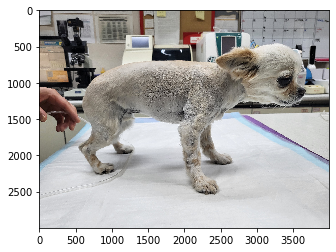

In [7]:
plt.imshow(image)

In [ ]:
cv2.imshow("Moon", img)
cv2.waitKey()
cv2.destroyAllWindows()

In [10]:
transfrom_image = train_transforms(image)

In [12]:
transfrom_image= transfrom_image.permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


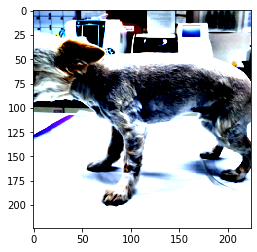

In [13]:
plt.imshow(transfrom_image)

In [18]:
class TorchvisionDataset(Dataset):
    def __init__(self, file_path, x, y , transform=None, cutout=None):
        self.file_path = file_path
        self.transform = transform
        self.cutout = cutout
        
        all_data = glob.glob(self.file_path + '*.jpg')
        
        all_file_lst = []
        for i in all_data:
            id_ = i.split('/')[-1].split('.')[0][-12:-3]
            body_part = i.split('/')[-1].split('.')[0][-2:]
        #     print(body_part)
            if (id_ in list(x)) and (body_part not in ['01','02','13','14','15','16','17','18','19','20']):
                all_file_lst.append(i)
                
        label_dic = {}       
        for i,j in zip(x,y):
            label_dic[i] =j
            
        
        
        file_paths=[]
        labels=[]
        for file in all_file_lst:
            id_ = file.split('/')[-1].split('.')[0][-12:-3]
            labels.append(label_dic[id_]-1)
            file_paths.append(file)
            
            
        self.file_paths = file_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with PIL
        image = Image.open(file_path)
        

        if self.transform:
            image = self.transform(image)
            
        if self.cutout:
            image = self.cutout(image)

        return file_path ,image, label

In [9]:
train_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(256),  # 사이즈 변경
        transforms.CenterCrop(224),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [20]:
train_dataset = TorchvisionDataset(data_dir,x_train,y_train,train_transforms)

In [21]:
len(train_dataset)

56

In [22]:
valid_dataset = TorchvisionDataset(data_dir,x_valid,y_valid,valid_transforms)

In [23]:
len(valid_dataset)

18

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=16,
                                             shuffle=True, num_workers=4)

valid_dataloader = DataLoader(valid_dataset, batch_size=8,
                                             shuffle=True, num_workers=4)
dataloaders = {'train' :train_dataloader, 'val' : valid_dataloader}


train_dataset_sizes = len(train_dataset)
valid_dataset_sizes = len(valid_dataset)


dataset_sizes = {'train' : train_dataset_sizes, 'val' : valid_dataset_sizes}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

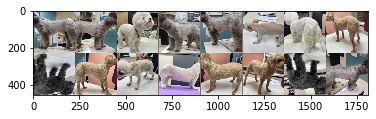

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
file_path, inputs, class_ = next(iter(train_dataloader))
# inputs, classes = train_datasets[0]

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for _, inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     print(outputs.shape)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [43]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 9)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.91)

In [44]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9013 Acc: 0.6607
val Loss: 1.1673 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.0682 Acc: 0.9821
val Loss: 0.9557 Acc: 0.6111

Epoch 2/24
----------
train Loss: 0.4492 Acc: 0.9107
val Loss: 3.1722 Acc: 0.5556

Epoch 3/24
----------
train Loss: 0.1994 Acc: 0.9286
val Loss: 3.3360 Acc: 0.2222

Epoch 4/24
----------
train Loss: 0.0337 Acc: 0.9821
val Loss: 2.4242 Acc: 0.3889

Epoch 5/24
----------
train Loss: 0.2337 Acc: 0.9286
val Loss: 1.1795 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.0406 Acc: 1.0000
val Loss: 0.9099 Acc: 0.6111

Epoch 7/24
----------
train Loss: 0.0245 Acc: 1.0000
val Loss: 1.6778 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.0345 Acc: 1.0000
val Loss: 1.8968 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.0349 Acc: 0.9821
val Loss: 1.9774 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.0084 Acc: 1.0000
val Loss: 2.0496 Acc: 0.4444

Epoch 11/24
----------
train Loss: 0.0094 Acc: 1.0000
val Loss: 2.1863 Acc: 0.4444

Ep

In [47]:
t = torch.Tensor([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
torch.max(t,1)

torch.return_types.max(
values=tensor([ 4.,  8., 12.]),
indices=tensor([3, 3, 3]))